In [6]:
import numpy as np

def n_body(t,x,p):
    """
    ODE function for the n-body problem.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]  # n_bodies = 3, dimensions = 2; dxdt[0:6] = x[6:12]

    # Initialize force matrices for each dimension
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    # Calculate forces between all pairs of bodies
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle

            # Calculate displacement vector between bodies i and j
            r_ij = []  # x, y
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                # print(f"Displacement between body {i} and body {j} in dimension {d}: {displacement}")
                r_ij.append(displacement)

            r_ij = np.array(r_ij)  # x, y displacement

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2))
            # print(f"Distance between body {i} and body {j}: {r}")

            # Calculate gravitational force magnitude
            force_mag = -G * masses[i] * masses[j] / (r**3)
            # print(f"Force magnitude between body {i} and body {j}: {force_mag}")

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # print("Force matrix x:")
    # print(force_matrices[0])
    # print("Force matrix y:")
    # print(force_matrices[1])

    # Sum forces on each body and calculate accelerations
    for i in range(n_bodies):
        if p.get('fix_first', False) and i == 0:
            # If fix_first is True, first body doesn't move
            continue

        # Calculate acceleration components for each dimension
        for d in range(dimensions):
            # print(force_matrices[d][i])
            total_force = np.sum(force_matrices[d][i])
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]  # vx1, vy1, vx2, vy2, vx3, vy3, [ax1, ay1,] ax2, ay2, ax3, ay3

    return dxdt

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ode_solver import *

# Using the n_body function provided in your document
def plot_position_and_velocity_space(t_span, state0, method, dt=0.01):
    """
    Plot position and velocity space for orbital motion using n_body function
    """
    # Set up parameters with Earth fixed at the origin
    G = 4*np.pi**2  # Gravitational constant in astronomical units
    p = {
        'm': [1.0, 0.001],  # masses (Earth, satellite)
        'G': G,
        'dimension': 2,
        'fix_first': True   # Earth is fixed
    }

    # Simulate using solve_ode
    t, states = solve_ode(n_body, t_span, state0, method, p, first_step=dt)

    # Extract satellite position and velocity components
    # State vector: [x1, y1, x2, y2, vx1, vy1, vx2, vy2]
    # Since Earth is fixed, we focus on the satellite (index 2)
    x = states[:, 2]
    y = states[:, 3]
    vx = states[:, 6]
    vy = states[:, 7]

    # Create figure with two subplots
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(1, 2, figure=fig)

    # Position space plot
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x, y)
    ax1.set_aspect('equal')
    ax1.set_xlabel('x (AU)')
    ax1.set_ylabel('y (AU)')
    ax1.set_title('Position Space')
    ax1.grid(True)

    # Add Earth at origin
    ax1.plot(0, 0, 'bo', markersize=10, label='Earth')
    ax1.legend()

    # Velocity space plot
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(vx, vy)
    ax2.set_aspect('equal')
    ax2.set_xlabel('vx (AU/yr)')
    ax2.set_ylabel('vy (AU/yr)')
    ax2.set_title('Velocity Space')
    ax2.grid(True)

    # Mark origin in velocity space
    ax2.plot(0, 0, 'k+', markersize=10, label='Origin')

    # Find and mark center of velocity circle
    vx_center = np.mean(vx)
    vy_center = np.mean(vy)
    ax2.plot(vx_center, vy_center, 'rx', markersize=8, label='Center (w)')
    ax2.legend()

    # Calculate angular momentum
    L = x*vy - y*vx
    L_avg = np.mean(L)

    # Calculate |u| = GM/L
    m_satellite = p['m'][1]
    u_mag_theory = p['G'] * p['m'][0] / abs(L_avg)
    u_mag_measured = np.mean(np.sqrt((vx-vx_center)**2 + (vy-vy_center)**2))

    # Print results for analysis
    print(f"Velocity space center (w vector): ({vx_center:.4f}, {vy_center:.4f})")
    print(f"Angular momentum L: {L_avg:.4f}")
    print(f"Theoretical |u| = GM/L: {u_mag_theory:.4f}")
    print(f"Measured radius in velocity space: {u_mag_measured:.4f}")

    plt.tight_layout()
    plt.show()

    return t, states, vx_center, vy_center

def analyze_velocity_space(t, states, p):
    """Analyze the velocity space orbit in detail"""
    # Extract satellite position and velocity
    x = states[:, 2]
    y = states[:, 3]
    vx = states[:, 6]
    vy = states[:, 7]

    # Find velocity space center (w vector)
    vx_center = np.mean(vx)
    vy_center = np.mean(vy)
    w = np.array([vx_center, vy_center])

    # Calculate angular momentum
    L = x*vy - y*vx
    L_avg = np.mean(L)

    # Calculate theoretical magnitude of u
    u_mag_theory = p['G'] * p['m'][0] / abs(L_avg)

    # Calculate measured u vectors
    u_x = vx - vx_center
    u_y = vy - vy_center
    u_mag_measured = np.sqrt(u_x**2 + u_y**2)

    # Calculate dot product between r and u to check perpendicularity
    r_dot_u = x*u_x + y*u_y

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot u magnitude compared to theory
    axes[0, 0].plot(t, u_mag_measured, 'b-', label='Measured |u|')
    axes[0, 0].axhline(u_mag_theory, color='r', linestyle='--', label='Theory: GM/|L|')
    axes[0, 0].set_xlabel('Time (yr)')
    axes[0, 0].set_ylabel('|u| (AU/yr)')
    axes[0, 0].legend()
    axes[0, 0].set_title('Magnitude of u vector')

    # Plot dot product to verify perpendicularity
    axes[0, 1].plot(t, r_dot_u)
    axes[0, 1].axhline(0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Time (yr)')
    axes[0, 1].set_ylabel('r·u')
    axes[0, 1].set_title('Perpendicularity check: r·u should be zero')

    # Plot velocity vector diagram for selected time points
    n_points = 5
    indices = np.linspace(0, len(t)-1, n_points, dtype=int)

    axes[1, 0].set_aspect('equal')
    for i in indices:
        # Plot velocity vector
        axes[1, 0].arrow(0, 0, vx[i], vy[i], head_width=0.05, head_length=0.1, fc='b', ec='b', label='v' if i==indices[0] else None)
        # Plot w vector
        axes[1, 0].arrow(0, 0, vx_center, vy_center, head_width=0.05, head_length=0.1, fc='r', ec='r', label='w' if i==indices[0] else None)
        # Plot u vector
        axes[1, 0].arrow(vx_center, vy_center, u_x[i], u_y[i], head_width=0.05, head_length=0.1, fc='g', ec='g', label='u' if i==indices[0] else None)

    axes[1, 0].grid(True)
    axes[1, 0].set_xlabel('vx (AU/yr)')
    axes[1, 0].set_ylabel('vy (AU/yr)')
    axes[1, 0].set_title('Velocity space vectors: v = w + u')
    axes[1, 0].legend()

    # Plot angular momentum and its constancy
    axes[1, 1].plot(t, L)
    axes[1, 1].axhline(L_avg, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Time (yr)')
    axes[1, 1].set_ylabel('Angular Momentum')
    axes[1, 1].set_title('Angular Momentum L = r × p')

    plt.tight_layout()
    plt.show()

    print(f"Center of velocity space (w vector): ({vx_center:.4f}, {vy_center:.4f})")
    print(f"Average angular momentum L: {L_avg:.4f}")
    print(f"Theoretical |u| = GM/|L|: {u_mag_theory:.4f}")
    print(f"Average measured |u|: {np.mean(u_mag_measured):.4f}")
    print(f"Average r·u dot product: {np.mean(np.abs(r_dot_u)):.8f}")

def apply_impulse_and_analyze(impulse_type='tangential', impulse_magnitude=0.5):
    """Simulate a satellite orbit with an impulse applied mid-orbit"""
    # Set up parameters
    G = 4*np.pi**2
    p = {
        'm': [1.0, 0.001],  # masses (Earth, satellite)
        'G': G,
        'dimension': 2,
        'fix_first': True   # Earth is fixed
    }

    # Initial state for circular orbit
    # [x1, y1, x2, y2, vx1, vy1, vx2, vy2]
    state0 = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2*np.pi])

    # First half of orbit (before impulse)
    t1, states1 = solve_ode(n_body, [0, 0.5], state0, RungeKutta, p, first_step=0.01)

    # Get final state and apply impulse
    final_state = states1[-1].copy()

    # Apply impulse to satellite velocity (vx2, vy2 at indices 6, 7)
    if impulse_type == 'tangential':
        # Tangential impulse (perpendicular to position vector)
        x, y = final_state[2:4]  # Satellite position
        r = np.sqrt(x**2 + y**2)
        # Unit tangential vector (-y, x)/r
        tx, ty = -y/r, x/r
        final_state[6] += impulse_magnitude * tx  # vx2
        final_state[7] += impulse_magnitude * ty  # vy2
    else:  # radial
        # Radial impulse (along position vector)
        x, y = final_state[2:4]  # Satellite position
        r = np.sqrt(x**2 + y**2)
        # Unit radial vector (x, y)/r
        rx, ry = x/r, y/r
        final_state[6] += impulse_magnitude * rx  # vx2
        final_state[7] += impulse_magnitude * ry  # vy2

    # Second half of orbit (after impulse)
    t2, states2 = solve_ode(n_body, [0.5, 3.0], final_state, RungeKutta, p, first_step=0.01)

    # Combine results
    t = np.concatenate([t1, t2[1:]])
    states = np.vstack([states1, states2[1:]])

    # Extract satellite position and velocity
    x = states[:, 2]
    y = states[:, 3]
    vx = states[:, 6]
    vy = states[:, 7]

    # Split data at impulse point
    split_idx = len(t1)
    x1, y1 = x[:split_idx], y[:split_idx]
    x2, y2 = x[split_idx:], y[split_idx:]
    vx1, vy1 = vx[:split_idx], vy[:split_idx]
    vx2, vy2 = vx[split_idx:], vy[split_idx:]

    # Create plots
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, figure=fig)

    # Position space plot
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x1, y1, 'b-', label='Before impulse')
    ax1.plot(x2, y2, 'r-', label='After impulse')
    ax1.plot(0, 0, 'bo', markersize=10, label='Earth')
    ax1.plot(states1[-1, 2], states1[-1, 3], 'go', markersize=8, label='Impulse point')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x (AU)')
    ax1.set_ylabel('y (AU)')
    ax1.set_title(f'Position Space with {impulse_type.capitalize()} Impulse')
    ax1.grid(True)
    ax1.legend()

    # Velocity space plot
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(vx1, vy1, 'b-', label='Before impulse')
    ax2.plot(vx2, vy2, 'r-', label='After impulse')
    ax2.plot(0, 0, 'k+', markersize=10, label='Origin')

    # Calculate and mark velocity space centers
    vx1_center = np.mean(vx1)
    vy1_center = np.mean(vy1)
    vx2_center = np.mean(vx2)
    vy2_center = np.mean(vy2)

    ax2.plot(vx1_center, vy1_center, 'bx', markersize=8, label='Before center (w1)')
    ax2.plot(vx2_center, vy2_center, 'rx', markersize=8, label='After center (w2)')

    # Show impulse in velocity space
    ax2.arrow(vx1[-1], vy1[-1], vx2[0]-vx1[-1], vy2[0]-vy1[-1],
              head_width=0.1, head_length=0.2, fc='g', ec='g', label='Impulse')

    ax2.set_aspect('equal')
    ax2.set_xlabel('vx (AU/yr)')
    ax2.set_ylabel('vy (AU/yr)')
    ax2.set_title(f'Velocity Space with {impulse_type.capitalize()} Impulse')
    ax2.grid(True)
    ax2.legend()

    # Energy plot
    ax3 = fig.add_subplot(gs[1, 0])

    # Calculate energy
    r = np.sqrt(x**2 + y**2)
    m_satellite = p['m'][1]
    KE = 0.5 * m_satellite * (vx**2 + vy**2)  # Kinetic energy
    PE = -p['G'] * p['m'][0] * m_satellite / r  # Potential energy
    E = KE + PE  # Total energy

    ax3.plot(t, E, 'g-', label='Total Energy')
    ax3.axvline(0.5, color='k', linestyle='--', label='Impulse')
    ax3.set_xlabel('Time (yr)')
    ax3.set_ylabel('Energy')
    ax3.set_title('Total Energy vs Time')
    ax3.grid(True)
    ax3.legend()

    # Angular momentum plot
    ax4 = fig.add_subplot(gs[1, 1])
    L = m_satellite * (x*vy - y*vx)  # Angular momentum

    ax4.plot(t, L, 'b-', label='Angular Momentum')
    ax4.axvline(0.5, color='k', linestyle='--', label='Impulse')
    ax4.set_xlabel('Time (yr)')
    ax4.set_ylabel('Angular Momentum')
    ax4.set_title('Angular Momentum vs Time')
    ax4.grid(True)
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # Print analysis
    print(f"Velocity space center before impulse: ({vx1_center:.4f}, {vy1_center:.4f})")
    print(f"Velocity space center after impulse: ({vx2_center:.4f}, {vy2_center:.4f})")
    print(f"Change in center (w vector): ({vx2_center-vx1_center:.4f}, {vy2_center-vy1_center:.4f})")
    print(f"Energy before impulse: {np.mean(E[:split_idx]):.4f}")
    print(f"Energy after impulse: {np.mean(E[split_idx:]):.4f}")
    print(f"Angular momentum before impulse: {np.mean(L[:split_idx]):.4f}")
    print(f"Angular momentum after impulse: {np.mean(L[split_idx:]):.4f}")

Velocity space center (w vector): (-0.0010, 0.0312)
Angular momentum L: 6.2832
Theoretical |u| = GM/L: 6.2832
Measured radius in velocity space: 6.2831


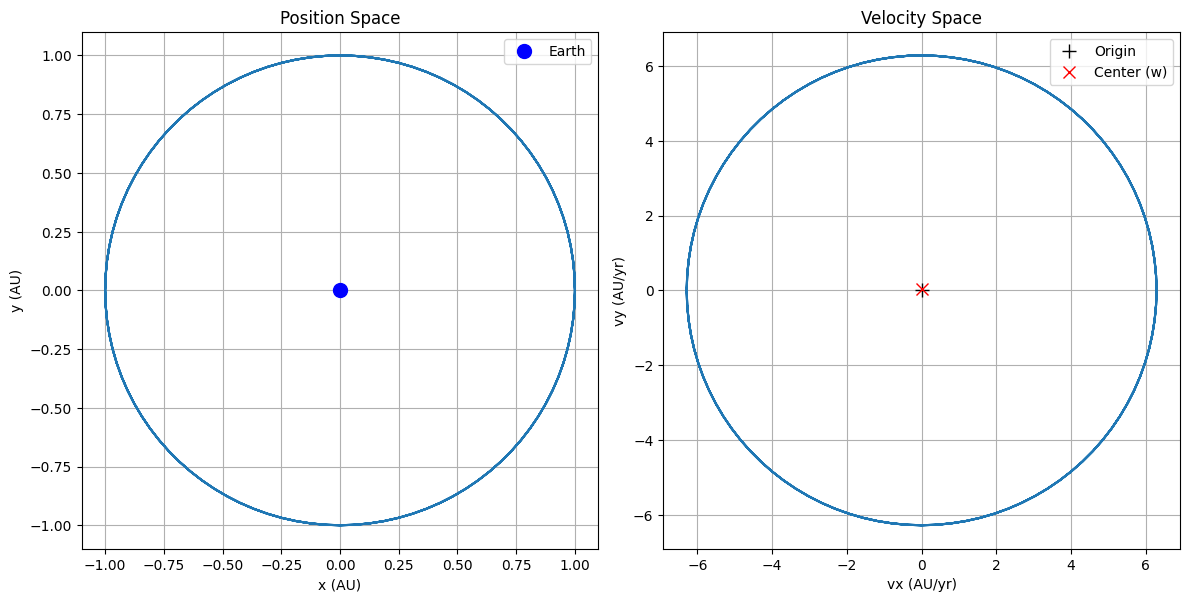

Velocity space center (w vector): (-0.5734, 0.4799)
Angular momentum L: 7.8540
Theoretical |u| = GM/L: 5.0265
Measured radius in velocity space: 4.1556


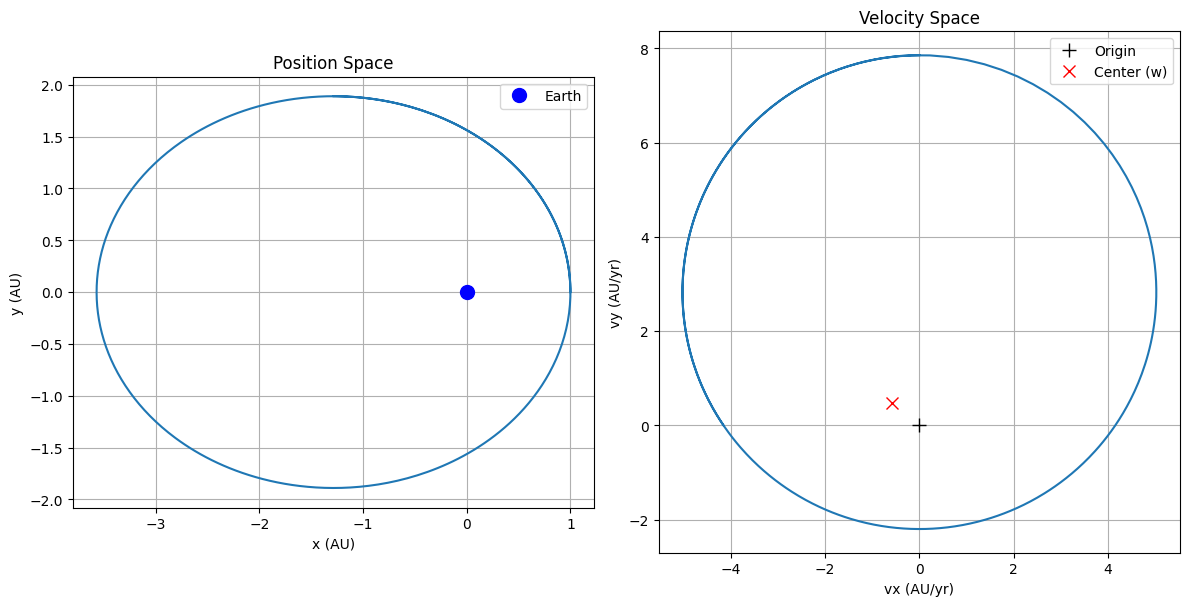

In [14]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Set up initial conditions for circular orbit
# State vector format: [x1, y1, x2, y2, vx1, vy1, vx2, vy2]
# Earth fixed at origin (0,0), satellite at (1,0) with velocity (0,2π)
state0_circular = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2*np.pi])

# Time span: 0 to 2 years (one complete orbit takes 1 year)
t_span = [0, 4]

# Call the function with the Runge-Kutta method
t_circular, states_circular, vx_center, vy_center = plot_position_and_velocity_space(
    t_span, state0_circular, RungeKutta, dt=0.01)

# For an elliptical orbit, increase the initial velocity
state0_elliptical = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.5*np.pi])

# Call the function for elliptical orbit
t_elliptical, states_elliptical, vx_center, vy_center = plot_position_and_velocity_space(
    t_span, state0_elliptical, RungeKutta, dt=0.01)